## Importa bibliotecas

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
from scipy.io import loadmat 
from functools import partial
import random

from PIL import Image
import matplotlib.image as mpimg
from scipy.spatial.distance import cdist

## Função para abrir imagem

In [2]:
def photo_open(filename, rescale=1):
    photo = Image.open(filename)
    photo = photo.convert('RGB')
    photo =photo.resize( ( int(photo.size[0]/rescale), int(photo.size[1]/rescale) ), Image.ANTIALIAS)
    return photo

## Captura os pixels da imagem e insere em um DataFrame

In [3]:
def pick_pixels(photo):
    n , m = photo.size
    imagem = []
    pixels = photo.load()
    for i in range(n):
        for j in range(m):
            imagem.append(list(pixels[i,j]) )
    return pd.DataFrame(imagem)

## k-means

In [4]:
def K_means(data_df, k):

    data_np = data_df.values
    lendata = len(data_np)

    idx = np.zeros((lendata,1))

    #Matriz de partições
    particao = np.zeros((lendata,k))

    ############################ Passo 1 ###############################
    #Atribuir cada ponto a um determido cluster de forma aleatória
    for i in range(lendata):
        rnd = np.random.randint(k)
        particao[i][rnd] = 1

    centr = calc_centroids(data_df, particao)
    dist_total = 0
    itr = 0

    for i in range(5):  
        ################### Passo 2 ##############################
        dist = np.zeros((lendata,1))
        particao[:,:] = 0
        for i in range(lendata):
            menor_dist = np.inf
            for j in range(k):
                data_atual = data_np[i,:]
                menor_dist_aux = np.linalg.norm(data_atual - centr[j,:])
                if menor_dist_aux <= menor_dist:
                    menor_dist = menor_dist_aux
                    idx[i] = j

            ################### Passo 3 ###############################
            dist[i] = menor_dist

            ###################### Passo 4 #############################
            particao[i][int(idx[i])] = 1

        dist_total_aux = np.sum(dist)
        
        itr += 1
            
        print('Valor de função objetivo: %d \nIteraçao: %d'% (dist_total_aux,itr))

        centr = calc_centroids(data_df, particao)
    
    # Obetem as cores dos pixels centrais
    centers = coresCentrais(dist, data_np, idx, k)
    return centers

## Calcula a nova posição dos centróides

In [5]:
# Funcao que obtem os centroides
def calc_centroids(data, partitions):
    
    #Número de características
    nfeatures = data.shape[1]
    
    #Número de partições
    K = partitions.shape[1]
    
    #K centroides com dimensões igual ao número de features
    centroids = np.zeros([K,nfeatures])
    
    #Valores do DataFrame de dados
    data_np = data.values
    
    #Cálcula a posição dos centóides
    for i in range(K):
        #Verifica quais amostras estão contidas no cluster i
        idx_nonzero =  np.flatnonzero(partitions[:,i])
        
        #Armazena o conteúdo presente no cluster i
        data_i = data_np[idx_nonzero,:]
        
        #Posiciona o centróide na posição média do cluster i 
        centroids[i] = np.mean(data_i, axis=0)
    return centroids

## Captura as cores centrais dos clusters

In [6]:
def coresCentrais(dist, data_np, idx, k):
    lendata = len(dist)
    closet_cluster = np.zeros((k, len(data_np[0])))

    for i in range(k):
        menor_dist_clus = np.inf

        for j in range(lendata):
            idx_int = int(idx[j])
            if idx_int == i:
                if dist[j] < menor_dist_clus:
                    menor_dist_clus = dist[j]
                    j_aux = j

        closet_cluster[i,:] = data_np[j_aux,:]

    centers = np.zeros((lendata,  len(data_np[0])))

    for i in range(k):
        for j in range(lendata):
            idx_int = int(idx[j])
            if idx_int == i:
                centers[j,:] = closet_cluster[i,:]
    
    return centers

## Altera a cor de todos pixels do clusters para a cor do pixel central

In [7]:
def coloring(photo, centers, rescale=1):
    n, m = photo.size
    pixels = photo.load()
    j_aux = 0
    
    for i in range(n):
        for j in range(m):
            data_corrent = centers[j_aux,:]  
            j_aux += 1
            numb = [int(number) for number in data_corrent] 
            
            #O pixel corrente recebe a cor do pixel mais próximo do cluster
            pixels[i,j] = tuple(numb)
    
    #Altera o tamanho da imagem
    photo = photo.resize( (int( photo.size[0]*rescale), int(photo.size[1]*rescale)), Image.ANTIALIAS)
    return photo

## Seleciona a imagem

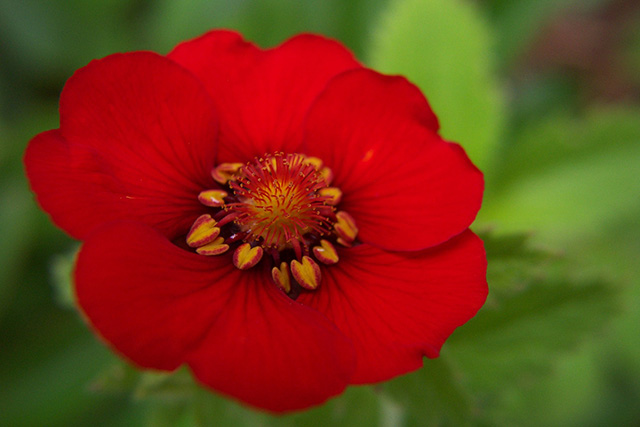

In [9]:
i = 1
if i <10:
    imagem = 'Imagens de Entrada\photo00' + str(i) +'.jpg'
else:
    imagem = 'Imagens de Entrada\photo0' + str(i) +'.jpg'
photo = photo_open(imagem)
photo

## Realiza a segmentação da imagem de acordo com o número de clusters 

Valor de função objetivo: 21147795 
Iteraçao: 1
Valor de função objetivo: 11495991 
Iteraçao: 2
Valor de função objetivo: 9636999 
Iteraçao: 3
Valor de função objetivo: 9618488 
Iteraçao: 4
Valor de função objetivo: 9616782 
Iteraçao: 5


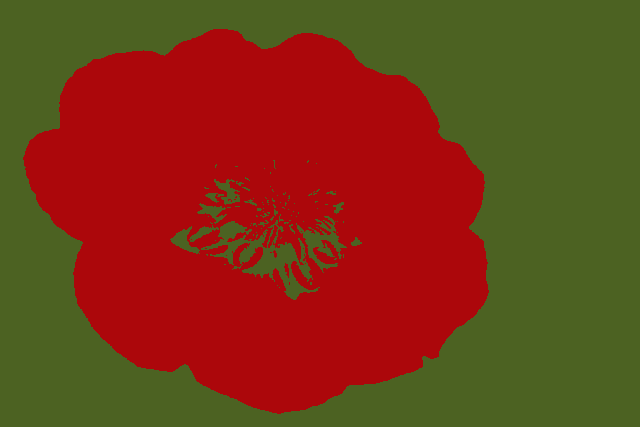

In [10]:
data_df = pick_pixels(photo)

data_np = data_df.values

# Número de clusters
k = 2

# Chama a função K-means
centers = K_means(data_df, k)

# Colore a imagem com a cor do pixels centrais
photo_mod = coloring(photo, centers)

photo_mod